In [2]:
import os
import glob
import re
import decimal

In [14]:
notebook = """Jupyter Notebook
dpll-template
Last Checkpoint: 3 godziny temu
(autosaved)
Current Kernel Logo
Logout
Python 3 Trusted
File
Edit
View
Insert
Cell
Kernel
Help
Run
In [1]:

import tensorflow as tf
from tensorflow.contrib import predictor
​
export_dir = "gs://neural-guidance-tensorflow/export/0315_series5a_sr50_l40_aTrue_tng-tpu-02/1552773431/"
predict_fn = predictor.from_saved_model(export_dir)
INFO:tensorflow:Restoring parameters from gs://neural-guidance-tensorflow/export/0315_series5a_sr50_l40_aTrue_tng-tpu-02/1552773431/variables/variables
In [2]:

from matplotlib import pyplot as plt
import numpy as np
import random
In [3]:

import sys 
sys.path.insert(0,'..')
In [4]:

from cnf_dataset import clauses_to_matrix
from dpll import DPLL, RandomClauseDPLL, MostCommonVarDPLL, RandomVarDPLL
from cnf import get_random_kcnf, CNF, get_sats_SR, get_pos_SR
from tqdm import tqdm
from collections import Counter
In [5]:

import math
from collections import defaultdict
​
def jw(clauses):
    score = defaultdict(int)
​
    for clause in clauses:
        for l in clause:
            score[l] += 2. ** (-len(clause))
​
    return max(score, key=score.get)
​
In [6]:

LIMIT_RUNS = 1000000
In [7]:

def shorten_cnf(cnf: CNF):
    for c in cnf.clauses:
        if len(c) == 1:
            # print("Chosen lone clause", c[0])
            return shorten_cnf(cnf.set_var(c[0]))
    all_literals = set(x
                       for clause in cnf.clauses
                       for x in clause)
    for v in cnf.vars:
        if v in all_literals and (-v) not in all_literals:
            # print("Chosen lone literal", v)
            return shorten_cnf(cnf.set_var(v))
        if (-v) in all_literals and v not in all_literals:
            # print("Chosen lone literal", -v)
            return shorten_cnf(cnf.set_var(-v))
    return cnf
​
def make_normalized(cls):
    class NormalizedDPLL(cls):
        def run(self, cnf: CNF):
            assert isinstance(cnf, CNF)
            self.number_of_runs += 1
            if self.number_of_runs > LIMIT_RUNS:
                return None
            
            cnf = shorten_cnf(cnf)
            if cnf.is_true():
                return []
            elif cnf.is_false():
                return None
​
            sug_var = self.suggest(cnf)
            sug_cnf = cnf.set_var(sug_var)
​
            sug_res = self.run(sug_cnf)
            if sug_res is not None:
                return [sug_var] + sug_res
​
            not_sug_cnf = cnf.set_var(-sug_var)
            not_sug_res = self.run(not_sug_cnf)
            if not_sug_res is not None:
                self.number_of_errors += 1
                return [-sug_var] + not_sug_res
            return None
    NormalizedDPLL.__name__ = "Normalized{}".format(cls.__name__)
    return NormalizedDPLL
In [8]:

np.set_printoptions(precision=3, suppress=True)
In [9]:

import tensorflow as tf
import os
​
BATCH_SIZE = 1
In [10]:

# Because we have to pass full batch
​
logfile = open("/tmp/log_2", "w")
#import sys
#logfile = sys.stdout
​
class GraphBasedDPLL(DPLL):
    def suggest(self, input_cnf: CNF):
        clause_num = len(input_cnf.clauses)
        var_num = max(input_cnf.vars)
        inputs = np.asarray([clauses_to_matrix(input_cnf.clauses, clause_num, var_num)] * BATCH_SIZE)
        
        policy_probs = predict_fn({"input": inputs})['policy_probabilities']
        
        print("CNF:", input_cnf, end=' ', file=logfile)
        print('cnf_clauses[0]', input_cnf.clauses, end=' ', file=logfile)
        print("probs:\n",  policy_probs[0], end='\n', file=logfile)
        
        best_prob = 0.0
        best_svar = None
        for var in input_cnf.vars:
            for svar in [var, -var]:
                svar_prob = policy_probs[0][var-1][0 if svar > 0 else 1]
                print(svar, svar_prob, best_prob, file=logfile)
                if svar_prob > best_prob:
                    best_prob = svar_prob
                    best_svar = svar
        print("best_svar:", best_svar, file=logfile)
        # print("Chosen neural", best_svar)
        return best_svar
​
class MostCommonDPLL(DPLL):
    def suggest(self, cnf: CNF):
        counter = Counter()
        for clause in cnf.clauses:
            for svar in clause:
                counter[svar] += 1
        return counter.most_common(1)[0][0]
    
class JeroslawDPLL(DPLL):
    def suggest(self, cnf: CNF):
        return jw(cnf.clauses)
    
​
class HumbleDPLL(DPLL):
    def suggest(self, input_cnf: CNF):
        clause_num = len(input_cnf.clauses)
        var_num = max(input_cnf.vars)
        inputs = np.asarray([clauses_to_matrix(input_cnf.clauses, clause_num, var_num)] * BATCH_SIZE)
        
        output = predict_fn({"input": inputs})
        policy_probs = output['policy_probabilities']
        sat_prob = output['sat_probabilities'][0]
        
        best_prob = 0.0
        best_svar = None
        for var in input_cnf.vars:
            for svar in [var, -var]:
                svar_prob = policy_probs[0][var-1][0 if svar > 0 else 1]
                #print(svar, svar_prob, best_prob, file=logfile)
                if svar_prob > best_prob:
                    best_prob = svar_prob
                    best_svar = svar
        if sat_prob < 0.3:
            # Overwriting with JW
            best_svar = jw(input_cnf.clauses)
        return best_svar    
In [11]:

NormalizedGraphBasedDPLL = make_normalized(GraphBasedDPLL)
NormalizedMostCommonDPLL = make_normalized(MostCommonDPLL)
NormalizedJeroslawDPLL = make_normalized(JeroslawDPLL)
NormalizedHumbleDPLL = make_normalized(HumbleDPLL)
In [19]:

class FastHumbleDPLL(DPLL):
    def run(self, cnf: CNF, fast=False):
        assert isinstance(cnf, CNF)
        self.number_of_runs += 1
        if self.number_of_runs > LIMIT_RUNS:
            return None
​
        cnf = shorten_cnf(cnf)
        if cnf.is_true():
            return []
        elif cnf.is_false():
            return None
​
        switch_to_heuristic, sug_var = self.suggest(cnf, fast)
        sug_cnf = cnf.set_var(sug_var)
​
        sug_res = self.run(sug_cnf, switch_to_heuristic)
        if sug_res is not None:
            return [sug_var] + sug_res
​
        not_sug_cnf = cnf.set_var(-sug_var)
        not_sug_res = self.run(not_sug_cnf, switch_to_heuristic)
        if not_sug_res is not None:
            self.number_of_errors += 1
            return [-sug_var] + not_sug_res
        return None
​
    def suggest(self, input_cnf: CNF, fast):
        if not fast:
            clause_num = len(input_cnf.clauses)
            var_num = max(input_cnf.vars)
            inputs = np.asarray([clauses_to_matrix(input_cnf.clauses, clause_num, var_num)] * BATCH_SIZE)
​
            output = predict_fn({"input": inputs})
            policy_probs = output['policy_probabilities']
            sat_prob = output['sat_probabilities'][0]
​
            best_prob = 0.0
            best_svar = None
            for var in input_cnf.vars:
                for svar in [var, -var]:
                    svar_prob = policy_probs[0][var-1][0 if svar > 0 else 1]
                    #print(svar, svar_prob, best_prob, file=logfile)
                    if svar_prob > best_prob:
                        best_prob = svar_prob
                        best_svar = svar
        if fast or sat_prob < 0.3:
            # Overwriting with JW
            best_svar = jw(input_cnf.clauses)
        return (fast or sat_prob < 0.3), best_svar    
In [12]:

def compute_steps(sats, dpll_cls):
    steps = []
    errors = []
    solved = 0
    for sat in tqdm(sats):
        dpll = dpll_cls()
        res = dpll.run(sat)
        # assert res is not None
        if res is not None:
            steps.append(dpll.number_of_runs)
            errors.append(dpll.number_of_errors)
            solved += 1
    print("Within {} steps solved {} problems out of {}".format(LIMIT_RUNS, solved, len(sats)))
    return steps, errors
In [13]:

def compute_and_print_steps(sats, dpll_cls):
    steps, errors = compute_steps(sats, dpll_cls)
    print("#Sats: {}; avg step: {:.2f}; stdev step: {:.2f}; avg error: {:.2f}; stdev error: {:.2f}".format(
        len(steps), np.mean(steps), np.std(steps), np.mean(errors), np.std(errors)))
    plt.figure(figsize=(14, 4))
    plt.subplot(1, 2, 1)
    plt.title("Steps of {}".format(dpll_cls.__name__))
    plt.hist(steps, bins=20) # range(2**(N+1)))
    plt.ylim((0, len(sats)))
    
    plt.subplot(1, 2, 2)
    plt.title("Errors of {}".format(dpll_cls.__name__))
    plt.hist(errors, bins=range(N+1))
    plt.ylim((0, len(sats)))
    plt.show()
In [22]:

def print_all(s, n, m, light=False):
    # def get_sats_SR(sample_number, min_variable_number, clause_number, max_variable_number=None):
    global S, N, M
    S = s
    N = n # number of clauses
    M = m # number of variables
    
    MAX_TRIES = 100000
    sats = []
    
    random.seed(1)
    np.random.seed(1)
    
    for index in range(MAX_TRIES):
        if len(sats) >= S:
            break
        sat = get_pos_SR(M, M, N)
        # if DPLL().run(sat) is not None:
        sats.append(sat)
    assert len(sats) == S
    # sats = get_sats_SR(S,M,N)
    # for sat in sats:
    #    print(sat)
    # assert len(sats) == S
    print("We have generated {} formulas".format(len(sats)))
    compute_and_print_steps(sats, FastHumbleDPLL)
    # compute_and_print_steps(sats, NormalizedMostCommonDPLL)
    compute_and_print_steps(sats, NormalizedJeroslawDPLL)
    # compute_and_print_steps(sats, NormalizedHumbleDPLL)
    if not light:
        compute_and_print_steps(sats, NormalizedGraphBasedDPLL)
​
    logfile.flush()
In [15]:

print_all(100, 200, 10)
100%|██████████| 100/100 [00:00<00:00, 533.40it/s]
We have generated 100 formulas
Within 1000 steps solved 100 problems out of 100
#Sats: 100; avg step: 8.14; stdev step: 3.90; avg error: 0.86; stdev error: 0.72


100%|██████████| 100/100 [00:00<00:00, 621.09it/s]
Within 1000 steps solved 100 problems out of 100
#Sats: 100; avg step: 7.33; stdev step: 3.55; avg error: 0.50; stdev error: 0.57

100%|██████████| 100/100 [00:53<00:00,  3.10it/s]
Within 1000 steps solved 100 problems out of 100
#Sats: 100; avg step: 5.56; stdev step: 1.86; avg error: 0.03; stdev error: 0.17

100%|██████████| 100/100 [00:32<00:00,  2.90it/s]
Within 1000 steps solved 100 problems out of 100
#Sats: 100; avg step: 5.64; stdev step: 2.56; avg error: 0.03; stdev error: 0.17

In [16]:

print_all(100, 200, 20)
 11%|█         | 11/100 [00:00<00:00, 103.55it/s]
We have generated 100 formulas
100%|██████████| 100/100 [00:01<00:00, 69.53it/s]
Within 1000 steps solved 100 problems out of 100
#Sats: 100; avg step: 23.56; stdev step: 17.36; avg error: 1.57; stdev error: 1.05

100%|██████████| 100/100 [00:01<00:00, 82.53it/s]
Within 1000 steps solved 100 problems out of 100
#Sats: 100; avg step: 18.65; stdev step: 11.41; avg error: 1.14; stdev error: 0.72

100%|██████████| 100/100 [01:27<00:00,  1.01it/s]
Within 1000 steps solved 100 problems out of 100
#Sats: 100; avg step: 15.43; stdev step: 15.85; avg error: 0.19; stdev error: 0.42

100%|██████████| 100/100 [01:36<00:00,  1.22s/it]
Within 1000 steps solved 100 problems out of 100
#Sats: 100; avg step: 17.83; stdev step: 22.51; avg error: 0.19; stdev error: 0.42

In [18]:

print_all(100, 500, 30)
  0%|          | 0/100 [00:00<?, ?it/s]
We have generated 100 formulas
100%|██████████| 100/100 [00:06<00:00, 17.88it/s]
Within 1000000 steps solved 100 problems out of 100
#Sats: 100; avg step: 53.31; stdev step: 48.86; avg error: 2.03; stdev error: 1.19

100%|██████████| 100/100 [00:04<00:00, 23.85it/s]
Within 1000000 steps solved 100 problems out of 100
#Sats: 100; avg step: 32.82; stdev step: 26.21; avg error: 1.22; stdev error: 0.79

100%|██████████| 100/100 [03:01<00:00,  1.02it/s]
Within 1000000 steps solved 100 problems out of 100
#Sats: 100; avg step: 28.40; stdev step: 45.56; avg error: 0.20; stdev error: 0.42

100%|██████████| 100/100 [04:12<00:00,  1.19s/it]
Within 1000000 steps solved 100 problems out of 100
#Sats: 100; avg step: 42.46; stdev step: 79.51; avg error: 0.21; stdev error: 0.43

In [15]:

print_all(100, 10000, 40, light=True)
  0%|          | 0/100 [00:00<?, ?it/s]
We have generated 100 formulas
100%|██████████| 100/100 [00:32<00:00,  2.38it/s]
Within 1000000 steps solved 100 problems out of 100
#Sats: 100; avg step: 190.63; stdev step: 167.22; avg error: 2.65; stdev error: 1.32

100%|██████████| 100/100 [00:13<00:00,  3.89it/s]
Within 1000000 steps solved 100 problems out of 100
#Sats: 100; avg step: 84.10; stdev step: 73.23; avg error: 1.86; stdev error: 1.08

100%|██████████| 100/100 [07:03<00:00,  4.12s/it]
Within 1000000 steps solved 100 problems out of 100
#Sats: 100; avg step: 71.88; stdev step: 132.42; avg error: 0.33; stdev error: 0.55

In [23]:

print_all(100, 10000, 50, light=True)
  0%|          | 0/100 [00:00<?, ?it/s]
We have generated 100 formulas
100%|██████████| 100/100 [07:16<00:00,  4.63s/it]
Within 1000000 steps solved 100 problems out of 100
#Sats: 100; avg step: 113.67; stdev step: 188.37; avg error: 0.54; stdev error: 0.82

100%|██████████| 100/100 [02:12<00:00,  1.67s/it]
Within 1000000 steps solved 100 problems out of 100
#Sats: 100; avg step: 514.93; stdev step: 439.86; avg error: 3.00; stdev error: 1.32

100%|██████████| 100/100 [00:38<00:00,  2.26it/s]
Within 1000000 steps solved 100 problems out of 100
#Sats: 100; avg step: 152.00; stdev step: 146.38; avg error: 2.03; stdev error: 1.10

In [24]:

print_all(30, 10000, 70, light=True)
  0%|          | 0/30 [00:00<?, ?it/s]
We have generated 30 formulas
100%|██████████| 30/30 [14:14<00:00, 18.94s/it]
Within 1000000 steps solved 30 problems out of 30
#Sats: 30; avg step: 1034.70; stdev step: 1554.57; avg error: 1.13; stdev error: 1.20

100%|██████████| 30/30 [07:42<00:00, 12.20s/it]
Within 1000000 steps solved 30 problems out of 30
#Sats: 30; avg step: 3431.60; stdev step: 3416.16; avg error: 5.07; stdev error: 1.63

100%|██████████| 30/30 [01:19<00:00,  1.02it/s]
Within 1000000 steps solved 30 problems out of 30
#Sats: 30; avg step: 614.37; stdev step: 708.74; avg error: 2.87; stdev error: 1.23

In [26]:

print_all(30, 10000, 90, light=True)

  0%|          | 0/30 [00:00<?, ?it/s]
We have generated 30 formulas

  3%|▎         | 1/30 [00:20<09:49, 20.31s/it]
  7%|▋         | 2/30 [00:27<07:34, 16.25s/it]
 10%|█         | 3/30 [00:35<06:19, 14.04s/it]
 13%|█▎        | 4/30 [00:43<05:17, 12.22s/it]
 17%|█▋        | 5/30 [02:22<15:54, 38.18s/it]
 20%|██        | 6/30 [03:53<21:33, 53.91s/it]
 23%|██▎       | 7/30 [04:01<15:25, 40.22s/it]
 27%|██▋       | 8/30 [04:07<10:56, 29.84s/it]
 30%|███       | 9/30 [04:15<08:13, 23.48s/it]
 33%|███▎      | 10/30 [04:23<06:17, 18.87s/it]
 37%|███▋      | 11/30 [04:35<05:17, 16.70s/it]
 40%|████      | 12/30 [15:34<1:02:49, 209.40s/it]
 43%|████▎     | 13/30 [25:07<1:30:14, 318.48s/it]
 47%|████▋     | 14/30 [25:23<1:00:42, 227.64s/it]
 50%|█████     | 15/30 [25:31<40:28, 161.91s/it]  
 53%|█████▎    | 16/30 [25:39<26:58, 115.64s/it]
 57%|█████▋    | 17/30 [26:46<21:54, 101.14s/it]
 60%|██████    | 18/30 [27:17<15:58, 79.87s/it] 
 63%|██████▎   | 19/30 [31:50<25:17, 137.98s/it]
 67%|██████▋   | 20/30 [31:52<16:12, 97.28s/it] 
 70%|███████   | 21/30 [33:57<15:49, 105.53s/it]
 73%|███████▎  | 22/30 [42:18<29:52, 224.11s/it]
 77%|███████▋  | 23/30 [42:52<19:29, 167.04s/it]
 80%|████████  | 24/30 [43:16<12:24, 124.03s/it]
 83%|████████▎ | 25/30 [43:53<08:09, 97.98s/it] 
 87%|████████▋ | 26/30 [46:27<07:39, 114.91s/it]
 90%|█████████ | 27/30 [47:20<04:48, 96.20s/it] 
 93%|█████████▎| 28/30 [50:57<04:25, 132.63s/it]
 97%|█████████▋| 29/30 [51:05<01:34, 94.98s/it] 
100%|██████████| 30/30 [52:43<00:00, 95.91s/it]
Within 1000000 steps solved 30 problems out of 30
#Sats: 30; avg step: 3057.73; stdev step: 4517.29; avg error: 1.33; stdev error: 1.11


  0%|          | 0/30 [00:00<?, ?it/s]
  3%|▎         | 1/30 [02:11<1:03:42, 131.82s/it]
  7%|▋         | 2/30 [04:39<1:03:40, 136.46s/it]
 10%|█         | 3/30 [07:56<1:09:40, 154.85s/it]
 13%|█▎        | 4/30 [09:25<58:25, 134.84s/it]  
 17%|█▋        | 5/30 [16:23<1:31:41, 220.07s/it]
 20%|██        | 6/30 [18:01<1:13:17, 183.21s/it]
 23%|██▎       | 7/30 [18:05<49:39, 129.56s/it]  
 27%|██▋       | 8/30 [22:09<1:00:03, 163.81s/it]
 30%|███       | 9/30 [26:58<1:10:31, 201.51s/it]
 33%|███▎      | 10/30 [29:41<1:03:18, 189.91s/it]
 37%|███▋      | 11/30 [37:03<1:24:03, 265.42s/it]
 40%|████      | 12/30 [39:04<1:06:39, 222.20s/it]
 43%|████▎     | 13/30 [43:18<1:05:37, 231.59s/it]
 47%|████▋     | 14/30 [43:34<44:34, 167.18s/it]  
 50%|█████     | 15/30 [47:53<48:40, 194.70s/it]
 53%|█████▎    | 16/30 [47:53<31:48, 136.32s/it]
 57%|█████▋    | 17/30 [49:22<26:26, 122.06s/it]
 60%|██████    | 18/30 [52:17<27:34, 137.91s/it]
 63%|██████▎   | 19/30 [55:04<26:52, 146.56s/it]
 67%|██████▋   | 20/30 [58:07<26:14, 157.42s/it]
 70%|███████   | 21/30 [1:03:14<30:20, 202.29s/it]
 73%|███████▎  | 22/30 [1:05:17<23:48, 178.56s/it]
 77%|███████▋  | 23/30 [1:05:34<15:10, 130.08s/it]
 80%|████████  | 24/30 [1:10:47<18:30, 185.10s/it]
 83%|████████▎ | 25/30 [1:18:27<22:17, 267.43s/it]
 87%|████████▋ | 26/30 [1:18:36<12:39, 189.95s/it]
 90%|█████████ | 27/30 [1:19:53<07:48, 156.21s/it]
 93%|█████████▎| 28/30 [1:23:15<05:39, 169.73s/it]
 97%|█████████▋| 29/30 [1:29:16<03:47, 227.12s/it]
100%|██████████| 30/30 [1:31:13<00:00, 194.11s/it]
Within 1000000 steps solved 30 problems out of 30
#Sats: 30; avg step: 24625.23; stdev step: 17007.14; avg error: 5.20; stdev error: 1.74


  0%|          | 0/30 [00:00<?, ?it/s]
  3%|▎         | 1/30 [00:36<17:51, 36.96s/it]
  7%|▋         | 2/30 [01:00<15:20, 32.86s/it]
 10%|█         | 3/30 [01:17<12:40, 28.15s/it]
 13%|█▎        | 4/30 [01:17<08:34, 19.79s/it]
 17%|█▋        | 5/30 [02:35<15:28, 37.13s/it]
 20%|██        | 6/30 [03:07<14:18, 35.79s/it]
 23%|██▎       | 7/30 [03:09<09:43, 25.39s/it]
 27%|██▋       | 8/30 [03:30<08:50, 24.13s/it]
 30%|███       | 9/30 [03:30<05:56, 16.96s/it]
 33%|███▎      | 10/30 [03:32<04:07, 12.37s/it]
 37%|███▋      | 11/30 [04:12<06:34, 20.79s/it]
 40%|████      | 12/30 [04:22<05:17, 17.62s/it]
 43%|████▎     | 13/30 [04:52<06:00, 21.18s/it]
 47%|████▋     | 14/30 [04:54<04:09, 15.58s/it]
 50%|█████     | 15/30 [05:26<05:08, 20.54s/it]
 57%|█████▋    | 17/30 [05:36<03:25, 15.84s/it]
 60%|██████    | 18/30 [06:08<04:07, 20.65s/it]
 63%|██████▎   | 19/30 [07:24<06:49, 37.24s/it]
 67%|██████▋   | 20/30 [07:29<04:35, 27.55s/it]
 70%|███████   | 21/30 [07:56<04:06, 27.36s/it]
 73%|███████▎  | 22/30 [08:08<03:03, 22.94s/it]
 80%|████████  | 24/30 [09:07<02:29, 24.88s/it]
 83%|████████▎ | 25/30 [09:13<01:36, 19.22s/it]
 87%|████████▋ | 26/30 [09:54<01:43, 25.76s/it]
 90%|█████████ | 27/30 [10:02<01:00, 20.22s/it]
 93%|█████████▎| 28/30 [10:32<00:46, 23.19s/it]
 97%|█████████▋| 29/30 [10:59<00:24, 24.45s/it]
100%|██████████| 30/30 [11:09<00:00, 20.16s/it]
Within 1000000 steps solved 30 problems out of 30
#Sats: 30; avg step: 3088.50; stdev step: 2859.22; avg error: 2.80; stdev error: 1.35

In [ ]:

print_all(30, 10000, 110, light=True)
In [*]:

print("hi")
In [ ]:

​


"""

In [15]:
lines = notebook.strip().split('\n')
filtered = [line for line in lines if ('avg step: ' in line) or ('print_all(' in line)][2:]

In [16]:
filtered

['print_all(100, 200, 10)',
 '#Sats: 100; avg step: 8.14; stdev step: 3.90; avg error: 0.86; stdev error: 0.72',
 '#Sats: 100; avg step: 7.33; stdev step: 3.55; avg error: 0.50; stdev error: 0.57',
 '#Sats: 100; avg step: 5.56; stdev step: 1.86; avg error: 0.03; stdev error: 0.17',
 '#Sats: 100; avg step: 5.64; stdev step: 2.56; avg error: 0.03; stdev error: 0.17',
 'print_all(100, 200, 20)',
 '#Sats: 100; avg step: 23.56; stdev step: 17.36; avg error: 1.57; stdev error: 1.05',
 '#Sats: 100; avg step: 18.65; stdev step: 11.41; avg error: 1.14; stdev error: 0.72',
 '#Sats: 100; avg step: 15.43; stdev step: 15.85; avg error: 0.19; stdev error: 0.42',
 '#Sats: 100; avg step: 17.83; stdev step: 22.51; avg error: 0.19; stdev error: 0.42',
 'print_all(100, 500, 30)',
 '#Sats: 100; avg step: 53.31; stdev step: 48.86; avg error: 2.03; stdev error: 1.19',
 '#Sats: 100; avg step: 32.82; stdev step: 26.21; avg error: 1.22; stdev error: 0.79',
 '#Sats: 100; avg step: 28.40; stdev step: 45.56; avg 

In [17]:
import re

def parse_stat(x):
    m = re.match("#Sats: \d+; avg step: ([0-9\.]+); stdev step: ([0-9\.d]+); avg error: [0-9\.]+; stdev error: [0-9\.]+", x)
    return (decimal.Decimal(m.group(1)), decimal.Decimal(m.group(2))) if m is not None else None

new_filtered = [parse_stat(x) if parse_stat(x) is not None else x for x in filtered]

In [18]:
new_filtered

['print_all(100, 200, 10)',
 (Decimal('8.14'), Decimal('3.90')),
 (Decimal('7.33'), Decimal('3.55')),
 (Decimal('5.56'), Decimal('1.86')),
 (Decimal('5.64'), Decimal('2.56')),
 'print_all(100, 200, 20)',
 (Decimal('23.56'), Decimal('17.36')),
 (Decimal('18.65'), Decimal('11.41')),
 (Decimal('15.43'), Decimal('15.85')),
 (Decimal('17.83'), Decimal('22.51')),
 'print_all(100, 500, 30)',
 (Decimal('53.31'), Decimal('48.86')),
 (Decimal('32.82'), Decimal('26.21')),
 (Decimal('28.40'), Decimal('45.56')),
 (Decimal('42.46'), Decimal('79.51')),
 'print_all(100, 10000, 40, light=True)',
 (Decimal('190.63'), Decimal('167.22')),
 (Decimal('84.10'), Decimal('73.23')),
 (Decimal('71.88'), Decimal('132.42')),
 'print_all(100, 10000, 50, light=True)',
 (Decimal('113.67'), Decimal('188.37')),
 (Decimal('514.93'), Decimal('439.86')),
 (Decimal('152.00'), Decimal('146.38')),
 'print_all(30, 10000, 70, light=True)',
 (Decimal('1034.70'), Decimal('1554.57')),
 (Decimal('3431.60'), Decimal('3416.16')),
 (

In [26]:
dlis = [new_filtered[x] for x in [1, 6, 11, 16, 21, 25, 29]]
jeroslaw = [new_filtered[x] for x in [2, 7, 12, 17, 22, 26, 30]]
humble = [new_filtered[x] for x in [3, 8, 13, 18, 20, 24, 28]]
graph = [new_filtered[x] for x in [4, 9, 14]]

In [27]:
x = [10, 20, 30, 40, 50, 70, 90, 110]

In [28]:
from matplotlib import pyplot as plt

In [29]:
graph

[(Decimal('5.64'), Decimal('2.56')),
 (Decimal('17.83'), Decimal('22.51')),
 (Decimal('42.46'), Decimal('79.51'))]

In [30]:
jeroslaw

[(Decimal('7.33'), Decimal('3.55')),
 (Decimal('18.65'), Decimal('11.41')),
 (Decimal('32.82'), Decimal('26.21')),
 (Decimal('84.10'), Decimal('73.23')),
 (Decimal('152.00'), Decimal('146.38')),
 (Decimal('614.37'), Decimal('708.74')),
 (Decimal('3088.50'), Decimal('2859.22'))]

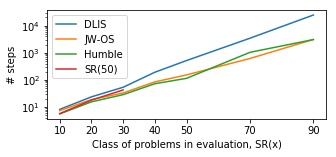

In [32]:
plt.figure(figsize=(5, 2))
plt.yscale('log',basey=10) 
plt.plot(x[:len(dlis)], [t[0] for t in dlis], '')
plt.plot(x[:len(jeroslaw)], [t[0] for t in jeroslaw], '')
plt.plot(x[:len(humble)], [t[0] for t in humble], '')
plt.plot(x[:len(graph)], [t[0] for t in graph], '')
plt.xticks(x[:-1])
plt.legend(['DLIS', 'JW-OS', 'Humble', 'SR(50)'])
plt.ylabel("# steps")
plt.xlabel("Class of problems in evaluation, SR(x)")
plt.savefig("sr-dpll-steps.pdf", bbox_inches = "tight")

In [59]:
import numpy
array = numpy.array([(dlis), (jeroslaw), (humble), (graph + [(numpy.nan, numpy.nan)] * 4)])

In [77]:
print(' \\\\\n'.join(' & '.join("{}±{}".format(value[0], value[1]) for value in row) for row in array))

8.14±3.90 & 23.56±17.36 & 53.31±48.86 & 190.63±167.22 & 514.93±439.86 & 3431.60±3416.16 & 24625.23±17007.14 \\
7.33±3.55 & 18.65±11.41 & 32.82±26.21 & 84.10±73.23 & 152.00±146.38 & 614.37±708.74 & 3088.50±2859.22 \\
5.56±1.86 & 15.43±15.85 & 28.40±45.56 & 71.88±132.42 & 113.67±188.37 & 1034.70±1554.57 & 3057.73±4517.29 \\
5.64±2.56 & 17.83±22.51 & 42.46±79.51 & nan±nan & nan±nan & nan±nan & nan±nan


[[[Decimal('8.14') Decimal('3.90')]
  [Decimal('23.56') Decimal('17.36')]
  [Decimal('53.31') Decimal('48.86')]
  [Decimal('190.63') Decimal('167.22')]
  [Decimal('514.93') Decimal('439.86')]
  [Decimal('3431.60') Decimal('3416.16')]
  [Decimal('24625.23') Decimal('17007.14')]]

 [[Decimal('7.33') Decimal('3.55')]
  [Decimal('18.65') Decimal('11.41')]
  [Decimal('32.82') Decimal('26.21')]
  [Decimal('84.10') Decimal('73.23')]
  [Decimal('152.00') Decimal('146.38')]
  [Decimal('614.37') Decimal('708.74')]
  [Decimal('3088.50') Decimal('2859.22')]]

 [[Decimal('5.56') Decimal('1.86')]
  [Decimal('15.43') Decimal('15.85')]
  [Decimal('28.40') Decimal('45.56')]
  [Decimal('71.88') Decimal('132.42')]
  [Decimal('113.67') Decimal('188.37')]
  [Decimal('1034.70') Decimal('1554.57')]
  [Decimal('3057.73') Decimal('4517.29')]]

 [[Decimal('5.64') Decimal('2.56')]
  [Decimal('17.83') Decimal('22.51')]
  [Decimal('42.46') Decimal('79.51')]
  [nan nan]
  [nan nan]
  [nan nan]
  [nan nan]]]
